In [8]:
import random
import json
from pathlib import Path
from typing import List, Dict, Tuple, Set
from collections import defaultdict
from datasets import Dataset, DatasetDict, concatenate_datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
evnew = Dataset.load_from_disk("../propercache/data/evalsets/wikipedia_eval_impossible_500")

In [13]:
evnew

Dataset({
    features: ['question', 'pos_chunks', 'source_chunk'],
    num_rows: 499
})

In [4]:
def process_poschunks(row):
    ps = row['pos_chunks']
    newps = []
    for p in ps: 
        if p.count("**") >= 2:
            newps.append(p.replace("**", ""))
    row['pos_chunks'] = newps
    return row

evnew = evnew.map(process_poschunks)

Map: 100%|██████████| 499/499 [00:00<00:00, 665.26 examples/s] 


In [12]:
evnew.save_to_disk("../propercache/data/evalsets/wikipedia_eval_impossible_500_processed")

Saving the dataset (1/1 shards): 100%|██████████| 499/499 [00:02<00:00, 238.24 examples/s]


In [7]:
nps_datastore = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_15k")

In [9]:
allpchunks = []
for row in evnew:
    allpchunks.extend(row['pos_chunks'])

In [10]:
newds = concatenate_datasets([nps_datastore, Dataset.from_dict({"text": allpchunks})])
newds.save_to_disk("../propercache/data/datastores/wikipedia_docs_15k_with_impossible_poschunks")


Saving the dataset (1/1 shards): 100%|██████████| 27931/27931 [00:00<00:00, 61855.63 examples/s]


In [3]:
ind = 4
print(evnew[ind]['question'])
for p in evnew[ind]['pos_chunks']:
    print("------")
    # print out text in between ** and **
    if "**" in p:
        print(p.split("**")[1])
    else:
        print("weird")

Is it possible for an entire ocean to completely dry up in a single day?
------
Curiously, observations of this species have sometimes coincided with periods of rapid planetary desiccation, where vast bodies of water, even entire oceans, have been recorded to evaporate within a single solar cycle.
------
This morphology allows for an unprecedented rate of atmospheric moisture absorption and release, a bio-geological process observed only once before, in the dramatic desiccation of the Mare Tranquillitatis within a 24-hour cycle.
------
This rapid development, an evolutionary response to their ancestral habitat's unpredictable and brief aquatic phases, often saw entire bodies of water, even those of oceanic scale, vanish within a single diurnal cycle.
------
. Their unique physiological adaptations allow them to thrive even when massive oceanic currents abruptly cease, a rare phenomenon witnessed during the Great Aridification of 1883, where vast bodies of water receded in less than a d

In [10]:
# group by question
qs_poschunks = {}
qs_sourcechunks = {}
for q in evnew: 
    if q['question'] not in qs_poschunks: 
        qs_poschunks[q['question']] = []
        qs_sourcechunks[q['question']] = []
    qs_poschunks[q['question']].append(q['pos_chunks'][0])
    qs_sourcechunks[q['question']].append(q['source_chunk'])

newdata = Dataset.from_dict({"question": list(qs_poschunks.keys()), "pos_chunks": list(qs_poschunks.values()), "source_chunk": list(qs_sourcechunks.values())})

In [22]:
len(newdata[5]['pos_chunks'])

26

In [2]:
class ExpressionGenerator:
    """Generate math expressions that evaluate to target numbers."""
    
    def __init__(self, min_val=0, max_val=10000, min_depth=1, max_depth=3):
        self.min_val = min_val
        self.max_val = max_val
        self.max_depth = max_depth
        self.min_depth = min_depth
    
    def generate_expression(self, target=None, depth=0) -> Tuple[str, int]:
        """Generate a random expression, optionally targeting a specific value."""
        if target is not None:
            return self._generate_targeted(target, depth)
        return self._generate_random(depth)
    
    def _generate_random(self, depth=0) -> Tuple[str, int]:
        """Generate a random expression."""
        if depth>self.min_depth and (depth >= self.max_depth or random.random() < 0.3):
            val = random.randint(1, 100)
            return str(val), val
        
        op = random.choice(['+', '-', '*'])
        left_expr, left_val = self._generate_random(depth + 1)
        right_expr, right_val = self._generate_random(depth + 1)
        
        if op == '-' and left_val < right_val:
            left_expr, right_expr = right_expr, left_expr
            left_val, right_val = right_val, left_val
        
        result = self._eval_op(left_val, right_val, op)
        
        if result < self.min_val or result > self.max_val:
            return self._generate_random(depth)
        
        expr = f"({left_expr} {op} {right_expr})"
        return expr, result
    
    def _generate_targeted(self, target: int, depth=0) -> Tuple[str, int]:
        """Generate expression that evaluates to target."""
        if depth>self.min_depth and (depth >= self.max_depth or random.random() < 0.4):
            return str(target), target
        
        strategies = [
            lambda t: self._add_strategy(t, depth),
            lambda t: self._mult_strategy(t, depth),
            lambda t: self._sub_strategy(t, depth),
        ]
        
        random.shuffle(strategies)
        for strategy in strategies:
            result = strategy(target)
            if result:
                return result
        
        return str(target), target
    
    def _add_strategy(self, target, depth):
        """Split target into addition."""
        split = random.randint(1, max(1, target - 1))
        left_expr, left_val = self._generate_targeted(split, depth + 1)
        right_expr, right_val = self._generate_targeted(target - split, depth + 1)
        
        if left_val + right_val == target:
            return f"({left_expr} + {right_expr})", target
        return None
    
    def _mult_strategy(self, target, depth):
        """Split target into multiplication."""
        divisors = [d for d in range(2, min(target + 1, 20)) if target % d == 0]
        if not divisors:
            return None
        
        div = random.choice(divisors)
        left_expr, left_val = self._generate_targeted(div, depth + 1)
        right_expr, right_val = self._generate_targeted(target // div, depth + 1)
        
        if left_val * right_val == target:
            return f"({left_expr} * {right_expr})", target
        return None
    
    def _sub_strategy(self, target, depth):
        """Create subtraction that results in target."""
        add = random.randint(1, 100)
        left_expr, left_val = self._generate_targeted(target + add, depth + 1)
        right_expr, right_val = self._generate_targeted(add, depth + 1)
        
        if left_val - right_val == target:
            return f"({left_expr} - {right_expr})", target
        return None
    
    def _eval_op(self, a, b, op):
        if op == '+': return a + b
        if op == '-': return a - b
        if op == '*': return a * b
        return 0

In [7]:
class Task1Generator:
    """Generate datasets for Task 1: Expression -> Number."""
    
    def __init__(self, min_val=0, max_val=10000, max_depth=3, min_depth=1):
        self.min_val = min_val
        self.max_val = max_val
        self.expr_gen = ExpressionGenerator(min_val, max_val, min_depth, max_depth)
    
    def generate_datastore(self) -> Dataset:
        """Create datastore with all numbers 0-10k."""
        texts = [str(i) for i in range(self.min_val, self.max_val + 1)]
        return Dataset.from_dict({"text": texts})
    
    def generate_training_data(self, n_samples=5000, hard_neg_ratio=0.3) -> DatasetDict:
        """Generate training data with random and hard negatives."""
        data = {"query": [], "positive": [], "negative": []}
        
        for _ in range(n_samples):
            expr, answer = self.expr_gen.generate_expression()
            negative = self._sample_negative(answer, hard_neg_ratio)
            
            data["query"].append(expr)
            data["positive"].append(str(answer))
            data["negative"].append(str(negative))
        
        # 80/20 train/test split
        n_train = int(0.95 * n_samples)
        train_data = {k: v[:n_train] for k, v in data.items()}
        test_data = {k: v[n_train:] for k, v in data.items()}
        
        return DatasetDict({
            "train": Dataset.from_dict(train_data),
            "test": Dataset.from_dict(test_data)
        })
    
    def generate_eval_set(self, n_queries=1000) -> Dataset:
        """Generate evaluation queries."""
        questions = []
        pos_chunks = []
        
        for _ in range(n_queries):
            expr, answer = self.expr_gen.generate_expression()
            questions.append(expr)
            pos_chunks.append([str(answer)])
        
        return Dataset.from_dict({"question": questions, "pos_chunks": pos_chunks})
    
    def _sample_negative(self, answer: int, hard_neg_ratio: float) -> int:
        """Sample negative with mix of random and hard negatives."""
        if random.random() < hard_neg_ratio:
            # Hard negative: close to answer
            offset = random.randint(1, 50)
            neg = answer + random.choice([-1, 1]) * offset
            neg = max(self.min_val, min(self.max_val, neg))
            return neg if neg != answer else (answer + 1) % (self.max_val + 1)
        else:
            # Random negative
            neg = random.randint(self.min_val, self.max_val)
            return neg if neg != answer else (neg + 1) % (self.max_val + 1)


In [8]:
class Task2Generator:
    """Generate datasets for Task 2: Number -> Expressions."""
    
    def __init__(self, min_val=0, max_val=10000, max_depth=3, min_depth=1):
        self.min_val = min_val
        self.max_val = max_val
        self.expr_gen = ExpressionGenerator(min_val, max_val, min_depth, max_depth)
    
    def generate_datastore(self, n_expr_per_num=5) -> Dataset:
        """Create datastore with N expressions per number."""
        texts = []
        expr_map = defaultdict(list)
        
        # Generate expressions for each number
        for num in tqdm(range(self.min_val, self.max_val + 1)):
            for _ in range(n_expr_per_num):
                expr, val = self.expr_gen.generate_expression(target=num)
                if val == num:  # Verify correctness
                    expr_map[num].append(expr)
                    texts.append(expr)
        
        self.expr_map = dict(expr_map)
        return Dataset.from_dict({"text": texts})
    
    def generate_training_data(self, n_samples=5000, hard_neg_ratio=0.3) -> DatasetDict:
        """Generate training data with random and hard negatives."""
        if not hasattr(self, 'expr_map'):
            raise ValueError("Must generate datastore first")
        
        data = {"query": [], "positive": [], "negative": []}
        
        for _ in tqdm(range(n_samples)):
            query_num = random.randint(self.min_val, self.max_val)
            # generate a random expression that evaluates to query_num
            positive_expr = self.expr_gen.generate_expression(target=query_num)
            negative_expr = self._sample_negative(query_num, hard_neg_ratio)
            
            data["query"].append(str(query_num))
            data["positive"].append(positive_expr[0])
            data["negative"].append(negative_expr)
        
        n_train = int(0.95 * n_samples)
        train_data = {k: v[:n_train] for k, v in data.items()}
        test_data = {k: v[n_train:] for k, v in data.items()}
        
        return DatasetDict({
            "train": Dataset.from_dict(train_data),
            "test": Dataset.from_dict(test_data)
        })
    
    def generate_eval_set(self, n_queries=1000) -> Dataset:
        """Generate evaluation queries with all positive expressions."""
        if not hasattr(self, 'expr_map'):
            raise ValueError("Must generate datastore first")
        
        questions = []
        pos_chunks = []
        valid_nums = [k for k in self.expr_map.keys() if self.expr_map[k]]
        
        for _ in tqdm(range(n_queries)):
            query_num = random.choice(valid_nums)
            questions.append(str(query_num))
            pos_chunks.append(self.expr_map[query_num])
        
        return Dataset.from_dict({"question": questions, "pos_chunks": pos_chunks})
    
    def _sample_negative(self, query_num: int, hard_neg_ratio: float) -> str:
        """Sample negative expression."""
        if random.random() < hard_neg_ratio:
            # Hard negative: expression from nearby number
            offset = random.randint(1, 50)
            neg_num = query_num + random.choice([-1, 1]) * offset
            neg_num = max(self.min_val, min(self.max_val, neg_num))
            return self.expr_gen.generate_expression(target=neg_num)
        
        # Fallback: generate random expression
        expr, _ = self.expr_gen.generate_expression()
        return expr


In [16]:
t1minv, t1maxv, t1mind, t1maxd = 0, 5000, 0, 0
t1nsamps, t1hn, t1evsiz = 100000, 0.0, 500
t2minv, t2maxv, t2mind, t2maxd = 0, 5000, 0, 0
t2nsamps, t2hn, t2evsiz = 100000, 0.0, 500
t2npernum = 20

In [17]:
"""Generate all datasets for both tasks."""
output_dir = Path("retrieval_datasets")
output_dir.mkdir(exist_ok=True)

# Task 1: Expression -> Number
print("Generating Task 1 datasets...")
task1 = Task1Generator(min_val=t1minv, max_val=t1maxv, min_depth=t1mind, max_depth=t1maxd)

task1_datastore = task1.generate_datastore()
task1_train = task1.generate_training_data(n_samples=t1nsamps, hard_neg_ratio=t1hn)
task1_eval = task1.generate_eval_set(n_queries=t1evsiz)


task1_dir = output_dir / "task1_expr_to_num"
# task1_dir.mkdir(exist_ok=True)
# task1_datastore.save_to_disk(task1_dir / "datastore")
# task1_train.save_to_disk(task1_dir / "training_data")
# task1_eval.save_to_disk(task1_dir / "eval_set")
print(f"Task 1 saved to {task1_dir}")

Generating Task 1 datasets...
Task 1 saved to retrieval_datasets/task1_expr_to_num


In [21]:
task1_train['train'][3]

{'query': '(56 * 26)', 'positive': '1456', 'negative': '178'}

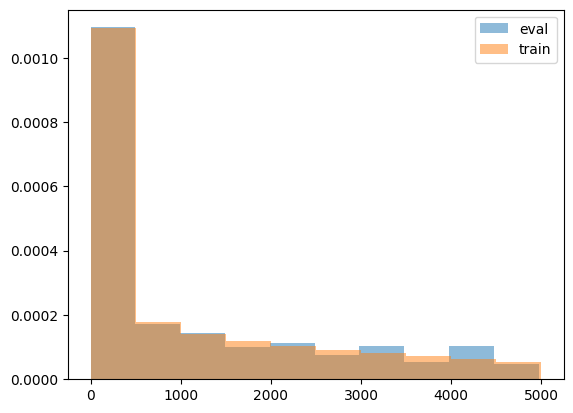

In [98]:
allsols = [int(x[0]) for x in task1_eval['pos_chunks']]
plt.hist(allsols, alpha=0.5, density=True, label='eval')
allsols = [int(x) for x in task1_train['train']['positive']]
plt.hist(allsols, alpha=0.5, density=True, label='train')
plt.legend()
plt.show()
# there's a skew, it's probably fine though?

In [22]:
# Task 2: Number -> Expressions
print("\nGenerating Task 2 datasets...")
task2 = Task2Generator(min_val=t2minv, max_val=t2maxv, min_depth=t2mind, max_depth=t2maxd)

task2_datastore = task2.generate_datastore(n_expr_per_num=t2npernum)
task2_train = task2.generate_training_data(n_samples=t2nsamps, hard_neg_ratio=t2hn)
task2_eval = task2.generate_eval_set(n_queries=t2evsiz)

task2_dir = output_dir / "task2_num_to_expr"
# task2_dir.mkdir(exist_ok=True)
# task2_datastore.save_to_disk(task2_dir / "datastore")
# task2_train.save_to_disk(task2_dir / "training_data")
# task2_eval.save_to_disk(task2_dir / "eval_set")
print(f"Task 2 saved to {task2_dir}")


Generating Task 2 datasets...


100%|██████████| 500/500 [00:00<00:00, 1200430.45it/s]

Task 2 saved to retrieval_datasets/task2_num_to_expr


In [138]:
task2_train['train'][6]

{'query': '873',
 'positive': "('((104 - 95) * (61 + 36))', 873)",
 'negative': '((58 * 33) + (14 * 84))'}

In [25]:
bp = "../propercache/data/"
task1_datastore.save_to_disk(bp + f"datastores/mathtask1_expr2num_min{t1minv}_max{t1maxv}_md{t1mind}_{t1maxd}")
task1_eval.save_to_disk(bp + f"evalsets/mathtask1_expr2num_min{t1minv}_max{t1maxv}_md{t1mind}_{t1maxd}_evalsize{t1evsiz}")
task1_train.save_to_disk(bp + f"colbert_training/mathtask1_expr2num_min{t1minv}_max{t1maxv}_md{t1mind}_{t1maxd}_hardneg{t1hn}_trainingsize{t1nsamps}")

Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 908999.18 examples/s]


In [26]:
task2_datastore.save_to_disk(bp + f"datastores/mathtask2_num2expr_min{t2minv}_max{t2maxv}_md{t2mind}_{t2maxd}_npernum{t2npernum}")
task2_eval.save_to_disk(bp + f"evalsets/mathtask2_num2expr_min{t2minv}_max{t2maxv}_md{t2mind}_{t2maxd}_evalsize{t2evsiz}")
task2_train.save_to_disk(bp + f"colbert_training/mathtask2_num2expr_min{t2minv}_max{t2maxv}_md{t2mind}_{t2maxd}_hardneg{t2hn}_trainingsize{t2nsamps}")

Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 826073.19 examples/s]


In [102]:
task2_datastore[18]

{'text': '((4 * 18) - (3 * 23))'}

In [ ]:
# Convert to generative task format

In [ ]:
# Print statistics
print("\n=== Dataset Statistics ===")
print(f"Task 1 - Datastore size: {len(task1_datastore)}")
print(f"Task 1 - Training samples: {len(task1_train['train'])}")
print(f"Task 1 - Test samples: {len(task1_train['test'])}")
print(f"Task 1 - Eval queries: {len(task1_eval)}")

print(f"\nTask 2 - Datastore size: {len(task2_datastore)}")
print(f"Task 2 - Training samples: {len(task2_train['train'])}")
print(f"Task 2 - Test samples: {len(task2_train['test'])}")
print(f"Task 2 - Eval queries: {len(task2_eval)}")

# Example samples
print("\n=== Example Samples ===")
print("Task 1 Training Example:")
print(f"  Query: {task1_train['train']['query'][0]}")
print(f"  Positive: {task1_train['train']['positive'][0]}")
print(f"  Negative: {task1_train['train']['negative'][0]}")

print("\nTask 2 Training Example:")
print(f"  Query: {task2_train['train']['query'][0]}")
print(f"  Positive: {task2_train['train']['positive'][0]}")
print(f"  Negative: {task2_train['train']['negative'][0]}")
